# Predicting sign-ups to a membership programme using neural network

The goal is to check what improvements neural networks offer compared to the logistic regression initially used to predict the sign-ups. The preprocessing is kept the same for most parts and detailed discussion on the steps can be found in the "Logistic regression - predicting leads sign-ups" notebook. The FastAI library is used implement the network.

## Preprocessing 

### Import the relevant libraries

In [1]:
from fastai.tabular.all import *
import pandas as pd
import numpy as np
import torch
import warnings

# turn off all warnings
warnings.filterwarnings('ignore')

### Load the dataset

In [2]:
# load data
dataset = pd.read_csv('regression_dataset.csv')

### Apply preprocessing steps
These operations will leave the dataset in the same shape it is in the "Logistic regression - predicting leads sign-ups" notebook prior to one-hot encoding.

In [3]:
# keep only leads 105 years old or younger
dataset2 = dataset[dataset['Age'] <= 105].copy()
# combine 3 Territories into 1 value
dataset2.loc[:,'Province'] = dataset2.loc[:,'Province'].replace(['Northwest Territories', 'Yukon', 'Nunavut'], 'Territories')
# drop unnecessary columns
dataset2.drop(columns = ['Called', 'Call Center', 'Call Outcome', 'Decision'], axis=1, inplace=True)
# display the dataset after changes
dataset2.head(10)

,Name,Phone Number,Province,Sport,Game Attendance,Age,Applied
0,Miya Charles,728190618071,New Brunswick,rugby,0.20,33,NaN
1,Deangelo Cobb,255217276432,Alberta,soccer,0.81,24,NaN
2,Adam Rogers,538482482123,Ontario,baseball,0.30,33,NaN
3,Demarion Dudley,913979679898,British Columbia,ice hockey,0.43,26,NaN
4,Scott Medina,676902221026,Ontario,ice hockey,0.36,25,NaN
5,Tessa Lowe,822568222276,Nova Scotia,rugby,0.66,29,NaN
6,Jaylin Bailey,422215394903,British Columbia,ice hockey,0.61,25,NaN
7,Francisco Curtis,775967173668,Alberta,soccer,0.40,20,True
8,Osvaldo Griffin,596918287046,British Columbia,cricket,0.30,28,NaN
9,Yoselin Moyer,242633357110,Ontario,tennis,0.31,22,False


The rest of the processing is contained in FastAI's DataLoaders object in a later part of the notebook. The next step is separating the dataset into train, test and predict sets.

## Separating the dataset
The separation into dataset_fit and dataset_predict is a copy of the code used in the "Logistic regression - predicting leads sign-ups" notebook.

In [4]:
# separate into dataset to be used for training and testing the network
dataset_fit = dataset2[~dataset2['Applied'].isna()].copy()
# and the dataset on which predictions will be made
dataset_predict = dataset2[dataset2['Applied'].isna()].copy()
# rename column Applied to Applying Probabilities
dataset_predict.rename(columns={'Applied': 'Applying Probability'}, inplace=True)
# change target data type from bool to int
dataset_fit['Applied'] = dataset_fit['Applied'].astype(int)
# see the value count in the dataframe for fitting (expecting 0s and 1s)
dataset_fit['Applied'].value_counts()

Applied
0    1928
1     760
Name: count, dtype: int64

### Splitting into train and test sets
FastAI's TrainTestSplitter method uses sklearns' train_test_split method.

In [5]:
# separate into training (&validation) and test set
train_indices, test_indices = TrainTestSplitter(test_size=0.2, random_state=42, stratify=dataset_fit['Applied'])(dataset_fit)
dataset_train = dataset_fit.iloc[train_indices]
dataset_test = dataset_fit.iloc[test_indices]

## Model & predictions

### Model building
Following the same logic as in "Logistic regression - predicting leads sign-ups" notebook, class weights are used and the Area Under the Precision-Recall Curve (AUPRC), also known as average precision, is used as the evaluation metric.

In [6]:
# check the imbalance in the training set
dataset_train['Applied'].value_counts()

Applied
0    1542
1     608
Name: count, dtype: int64

In [7]:
# using the values from above define class weights, inversely proportional to the class size
weights = torch.tensor([608,1542], dtype=torch.float32)
# create custom loss function taking the weights into account
loss_func = CrossEntropyLossFlat(weight=weights)

In [8]:
# define the evaluation metric
AUPRC = APScoreBinary()

FastAI's models use DataLoaders objects for feeding the model data for training. For this particular task a DataLoaders is created from a TabularPandas object which provides a wrapper around dataset_train DataFrame to prepare it for machine learning models.

In [9]:
# create a DataLoaders for tabular learner
dls = TabularPandas(
    # the dataset to be used
    dataset_train, 
    # division into train and validation sets
    splits = RandomSplitter(seed=42)(dataset_train),
    # define data processing steps - the data have only been processed partially so far, as mentioned earlier
    # Categorify: performs categorical embedding on categorical features. This is considered the preferred way of dealing with
    # categorical features and is done instead of one-hot-encoding.
    # Normalize: standardizes continuous variables (subtracts the mean and divides by the standard deviation).
    procs = [Categorify, Normalize],
    # categorical features
    cat_names=["Province","Sport"],
    # continuous features
    cont_names=["Game Attendance","Age"],
    # target variable
    y_names="Applied",
    # type of the target variable - categories (0 or 1)
    y_block = CategoryBlock(),
).dataloaders(path=".")

Three neural networks are trained and compared using the validation set to see which is best-suited for the dataset under analysis. Each of the networks has 2 hidden layers, as more should not be necessary for the task at hand. The difference between the networks is in the number of neurons in hidden layers: [5,5], [20,20], [100,100].

### [5,5] network

In [10]:
# declare a FastAI Learner object containing the data and the model
learn55 = tabular_learner(dls, metrics=AUPRC, layers=[5,5], loss_func=loss_func)

SuggestedLRs(valley=0.013182567432522774)

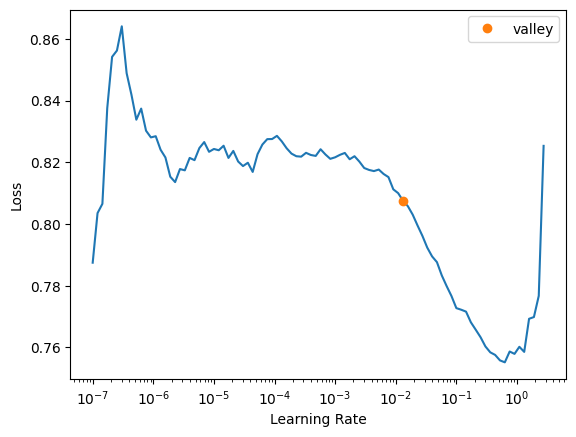

In [11]:
# find the optimal learning rate
learn55.lr_find()

In [12]:
# train the model using fit_one_cycle method which uses Leslie Smith's 1cycle policy
# the model is trained for 15 epochs and SaveModelCallback registers the model with best average precision
learn55.fit_one_cycle(15, lr_max=1e-1, cbs=SaveModelCallback(monitor='average_precision_score', min_delta=0.001))

epoch,train_loss,valid_loss,average_precision_score,time
0,0.718645,0.646274,0.444403,00:00
1,0.678782,0.649213,0.482476,00:00
2,0.663292,0.629585,0.514609,00:00
3,0.658573,0.652216,0.483231,00:00
4,0.663918,0.651083,0.464148,00:00
5,0.658430,0.650844,0.503337,00:00
6,0.655416,0.631048,0.499556,00:00
7,0.650992,0.635130,0.483132,00:00
8,0.647604,0.649623,0.498259,00:00
9,0.646457,0.625498,0.500285,00:00


Better model found at epoch 0 with average_precision_score value: 0.44440265198561524.
Better model found at epoch 1 with average_precision_score value: 0.48247635297840497.
Better model found at epoch 2 with average_precision_score value: 0.5146086068177287.


### [20,20] network

In [13]:
# declare a FastAI Learner object containing the data and the model
learn2020 = tabular_learner(dls, metrics=AUPRC, layers=[20,20], loss_func=loss_func)

SuggestedLRs(valley=0.0014454397605732083)

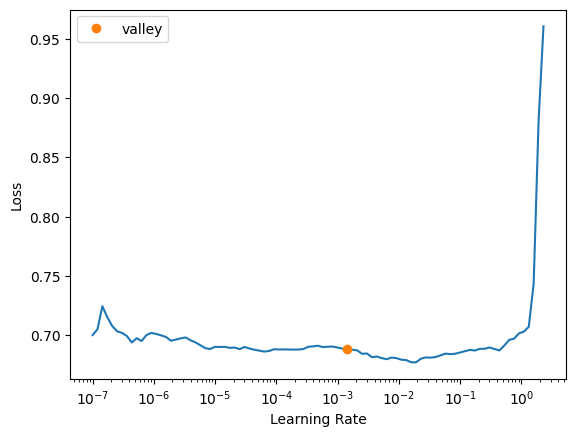

In [14]:
# find the optimal learning rate
learn2020.lr_find()

In [15]:
# train the model using fit_one_cycle method which uses Leslie Smith's 1cycle policy
# the model is trained for 15 epochs and SaveModelCallback registers the model with best average precision
learn2020.fit_one_cycle(15, lr_max=1e-2, cbs=SaveModelCallback(monitor='average_precision_score', min_delta=0.001))

epoch,train_loss,valid_loss,average_precision_score,time
0,0.675131,0.663572,0.448176,00:00
1,0.660988,0.634144,0.484101,00:00
2,0.654858,0.636455,0.492615,00:00
3,0.652202,0.634983,0.517904,00:00
4,0.650769,0.635332,0.493979,00:00
5,0.645478,0.635316,0.502035,00:00
6,0.641929,0.633407,0.509111,00:00
7,0.640483,0.633740,0.505284,00:00
8,0.639402,0.632392,0.500303,00:00
9,0.633570,0.631883,0.508729,00:00


Better model found at epoch 0 with average_precision_score value: 0.44817569818774705.
Better model found at epoch 1 with average_precision_score value: 0.48410081818373996.
Better model found at epoch 2 with average_precision_score value: 0.49261523672192387.
Better model found at epoch 3 with average_precision_score value: 0.5179035587108431.


### [100,100] network

In [16]:
# declare a FastAI Learner object containing the data and the model
learn100100 = tabular_learner(dls, metrics=AUPRC, layers=[100,100], loss_func=loss_func)

SuggestedLRs(valley=0.001737800776027143)

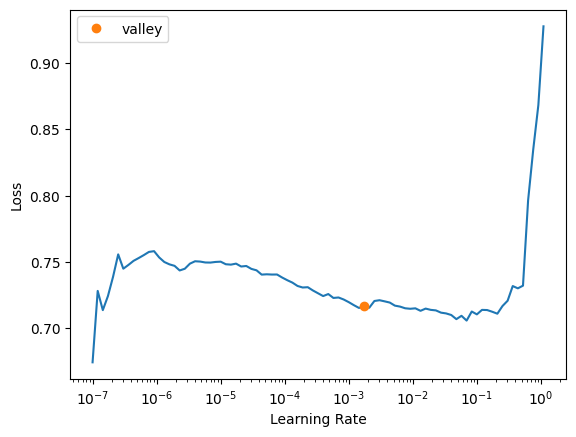

In [17]:
# find the optimal learning rate
learn100100.lr_find()

In [18]:
# train the model using fit_one_cycle method which uses Leslie Smith's 1cycle policy
# the model is trained for 15 epochs and SaveModelCallback registers the model with best average precision
learn100100.fit_one_cycle(15, lr_max=1e-2, cbs=SaveModelCallback(monitor='average_precision_score', min_delta=0.001))

epoch,train_loss,valid_loss,average_precision_score,time
0,0.684633,0.676257,0.362058,00:00
1,0.684005,0.647208,0.465692,00:00
2,0.677673,0.639866,0.479706,00:00
3,0.668074,0.636587,0.490220,00:00
4,0.663651,0.644822,0.489876,00:00
5,0.655067,0.626439,0.502416,00:00
6,0.656111,0.644244,0.472408,00:00
7,0.649010,0.634526,0.505480,00:00
8,0.640667,0.657409,0.478772,00:00
9,0.636892,0.643824,0.486286,00:00


Better model found at epoch 0 with average_precision_score value: 0.3620576551585959.
Better model found at epoch 1 with average_precision_score value: 0.4656917333087076.
Better model found at epoch 2 with average_precision_score value: 0.47970633408893737.
Better model found at epoch 3 with average_precision_score value: 0.4902195420300568.
Better model found at epoch 5 with average_precision_score value: 0.5024155507827789.
Better model found at epoch 7 with average_precision_score value: 0.5054797559942739.


The models are quite similar in terms of the best average precision score and all improve on the logistic regression validation results. Therefore, to reduce the risk of overfitting, the simplest, [5,5], network is chosen.

### Model evaluation

In [19]:
# perform the exact same processing on the test set as on the training set
test_dl = learn55.dls.test_dl(dataset_test)
# get predictions and targets
test_preds, test_targets = learn55.get_preds(dl=test_dl)
# extract probabilities of belonging to the positive class
y_pred_proba_test = test_preds[:, 1]
# display the average precision score for the test data 
print('Average precision score: {0}'.format(round(AUPRC(y_pred_proba_test, test_targets),3)))

Average precision score: 0.482


The difference between validation and test AUPRC scores suggests that the model did not overfit. The AUPRC score of 48.2% is also an improvement on the results of the logistic regression. Below, the model is used to make predictions. 

In [20]:
# perform the exact same processing on the predict set as on the training and test sets
predict_dl = learn55.dls.test_dl(dataset_predict, with_labels=False)
# get predictions
preds, _ = learn55.get_preds(dl=predict_dl)
# extract probabilities of belonging to the positive class
y_pred_proba = preds[:, 1]
# add results to the dataset
dataset_predict['Applying Probability'] = np.round(y_pred_proba,3)
# sort the uncalled leads from the biggest probability to apply to the smallest
dataset_predict = dataset_predict.sort_values(by='Applying Probability', ascending=False)
# display the dataframe
dataset_predict.head(10)

,Name,Phone Number,Province,Sport,Game Attendance,Age,Applying Probability
6012,Jalen Munoz,953081145902,Territories,baseball,0.95,34,0.850
4215,Barrett Davies,872706367564,Territories,tennis,0.87,20,0.832
2340,Malakai Goodman,99119489837,Saskatchewan,cricket,0.98,35,0.831
2017,Londyn Hawkins,389324709496,Territories,cricket,0.85,22,0.830
8093,Samson Morse,789008148185,Ontario,soccer,0.97,22,0.830
4003,Lainey Olsen,308136338463,Saskatchewan,soccer,0.94,19,0.827
1174,Zain Douglas,616222067438,Ontario,baseball,0.99,28,0.826
2917,Salma Koch,38618072022,Saskatchewan,soccer,0.96,43,0.823
5009,Aldo Jefferson,119552201307,Ontario,baseball,0.97,24,0.822
1271,Fernando Conner,496562654379,Ontario,soccer,0.96,39,0.819


In [21]:
# check the probability of the 100th most likely to apply person
dataset_predict.iloc[99, dataset_predict.columns.get_loc('Applying Probability')]

0.764

In [22]:
# save the results to a new dataframe
best_leads = dataset_predict.iloc[:100][['Name', 'Phone Number', 'Applying Probability']]
best_leads.head(10)

,Name,Phone Number,Applying Probability
6012,Jalen Munoz,953081145902,0.850
4215,Barrett Davies,872706367564,0.832
2340,Malakai Goodman,99119489837,0.831
2017,Londyn Hawkins,389324709496,0.830
8093,Samson Morse,789008148185,0.830
4003,Lainey Olsen,308136338463,0.827
1174,Zain Douglas,616222067438,0.826
2917,Salma Koch,38618072022,0.823
5009,Aldo Jefferson,119552201307,0.822
1271,Fernando Conner,496562654379,0.819


The obtained dataframe contains names, phone numbers and application probabilities of 100 most promising leads. The dataframe can be exported to csv using the following line of code:

best_leads.to_csv('best_leads.csv', index=False)